In [27]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import pickle
import seaborn as sns
import tqdm

In [28]:
# FH_AD_ChrGenePCA_00_GS10_v1_2500bp_summary
exp_list = [
    {'name': 'GenePCA_00_GS10_v1', 'evr': 0.7},
    {'name': 'GenePCA_00_GS10_v2', 'evr': 0.9},
    {'name': 'GenePCA_00_GS1_v2', 'evr': 0.9}]

In [29]:
def get_num_snps(pca_folder, pca_fname):
    with open(f'{pca_folder}/{pca_fname}', 'rb') as f:
        pca = pickle.load(f)
    num_snps = pca.components_.shape[1]
    return num_snps

for exp_dict in exp_list:
    summ_df = pd.read_csv(f'./NN_Logs/FH_AD_Chr{exp_dict["name"]}_2500bp_summary.csv')
    meta_agg = []
    for chrom in tqdm.tqdm(range(1, 23)):
        pca_folder = f'/mnt/sdf/GWANN_PCA_models/EVR_{exp_dict["evr"]}/{chrom}'
        meta = pd.read_csv(f'{pca_folder}/metadata.txt', sep='\t', header=None)
        meta.columns = ['pca_fname', 'evr']
        meta['num_snps'] = meta['pca_fname'].apply(lambda x: get_num_snps(pca_folder, x)).values
        meta['Gene'] = meta['pca_fname'].apply(lambda x: x.replace('pca_', '').replace('.pkl', '')).values
        meta['Gene'] = meta['Gene'].apply(lambda x: f'{x.split("_")[0]}:{x.split("_")[1]}-{x.split("_")[2]}').values
        meta = meta[['Gene', 'num_snps', 'evr']]
        meta_agg.append(meta)
    meta_agg = pd.concat(meta_agg)
    summ_df = pd.merge(summ_df, meta_agg, on='Gene', how='inner')
    summ_df = summ_df[['Gene', 'Chrom', 'num_snps', 'evr', 'Acc']]
    # summ_df['EVR_range'] = f'{exp_dict["evr"]:.2f}-{exp_dict["evr"]+0.05:.2f}'
    summ_df['exp_name'] = f'EVR:{exp_dict["evr"]:.2f}-{exp_dict["evr"]+0.05:.2f}'
    summ_df['exp_name'] += f'_{exp_dict["name"].split("_")[-2]}'
    print(summ_df.head())
    exp_dict['summ_df'] = summ_df
    

100%|██████████| 22/22 [00:03<00:00,  6.73it/s]


                  Gene  Chrom  num_snps       evr       Acc  \
0  1:17643054-19198141      1      5097  0.704788  0.497862   
1  1:11963692-14687947      1      5828  0.705810  0.504869   
2  1:19198414-21773762      1      7837  0.742515  0.494181   
3    1:3257739-4645928      1      5238  0.736471  0.496496   
4  1:21773894-24382484      1      6912  0.720999  0.497744   

             exp_name  
0  EVR:0.70-0.75_GS10  
1  EVR:0.70-0.75_GS10  
2  EVR:0.70-0.75_GS10  
3  EVR:0.70-0.75_GS10  
4  EVR:0.70-0.75_GS10  


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


                Gene  Chrom  num_snps       evr       Acc            exp_name
0  1:1689762-2559734      1      2375  0.899994  0.491746  EVR:0.90-0.95_GS10
1  1:4938808-5382005      1      1822  0.922236  0.494953  EVR:0.90-0.95_GS10
2   1:717587-1689164      1      2475  0.906999  0.496200  EVR:0.90-0.95_GS10
3  1:4159397-4535051      1      1822  0.935516  0.496972  EVR:0.90-0.95_GS10
4  1:4535148-4938510      1      1822  0.903611  0.501128  EVR:0.90-0.95_GS10


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]

                Gene  Chrom  num_snps       evr       Acc           exp_name
0   1:717587-1689164      1      2475  0.906999  0.502019  EVR:0.90-0.95_GS1
1  1:4535148-4938510      1      1822  0.903611  0.501069  EVR:0.90-0.95_GS1
2  1:2560735-3245799      1      1984  0.902633  0.494181  EVR:0.90-0.95_GS1
3  1:5382279-5889974      1      1543  0.911436  0.496200  EVR:0.90-0.95_GS1
4  1:3246093-3564850      1      1120  0.914358  0.502019  EVR:0.90-0.95_GS1


In [30]:
plot_df = []
for exp_dict in exp_list:
    plot_df.append(exp_dict['summ_df'])
plot_df = pd.concat(plot_df).reset_index(drop=True)

### EVR_range vs SNP count

<AxesSubplot:xlabel='num_snps', ylabel='Count'>

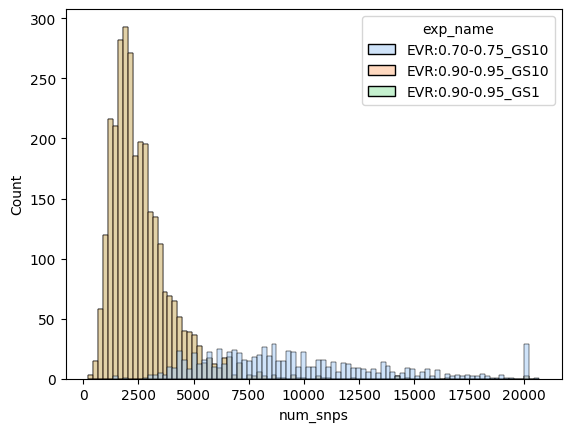

In [31]:
sns.histplot(data=plot_df, x='num_snps', alpha=0.5, 
             hue='exp_name', palette='pastel')

### EVR vs Acc (facetted by evr range)

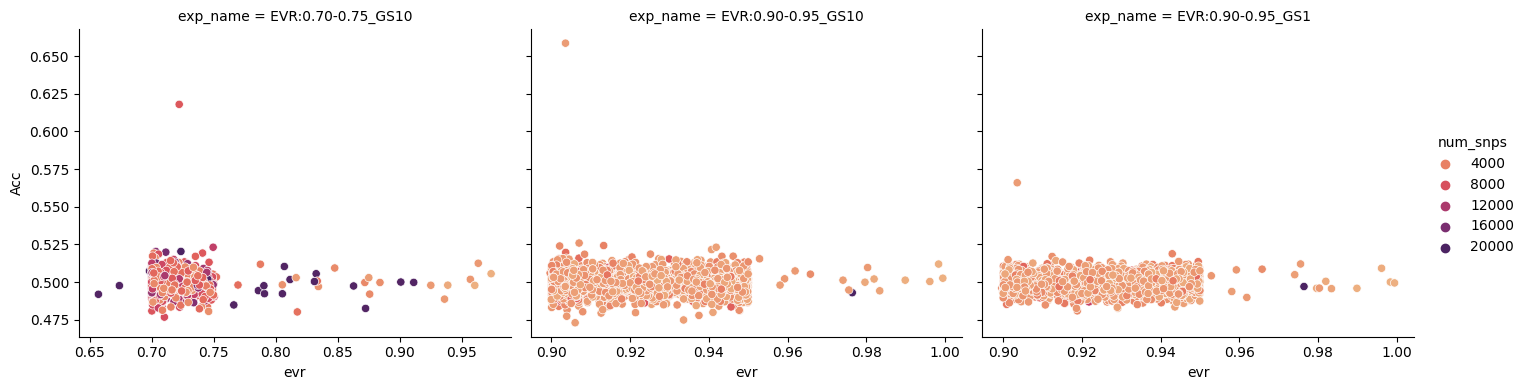

In [32]:
fg = sns.FacetGrid(data=plot_df, col='exp_name', sharey=True, sharex=False, height=4, aspect=1.2)
fg.map_dataframe(sns.scatterplot, x='evr', y='Acc', hue='num_snps', alpha=1, palette='flare')
fg.add_legend(title='num_snps')
plt.show()


### Manhattan

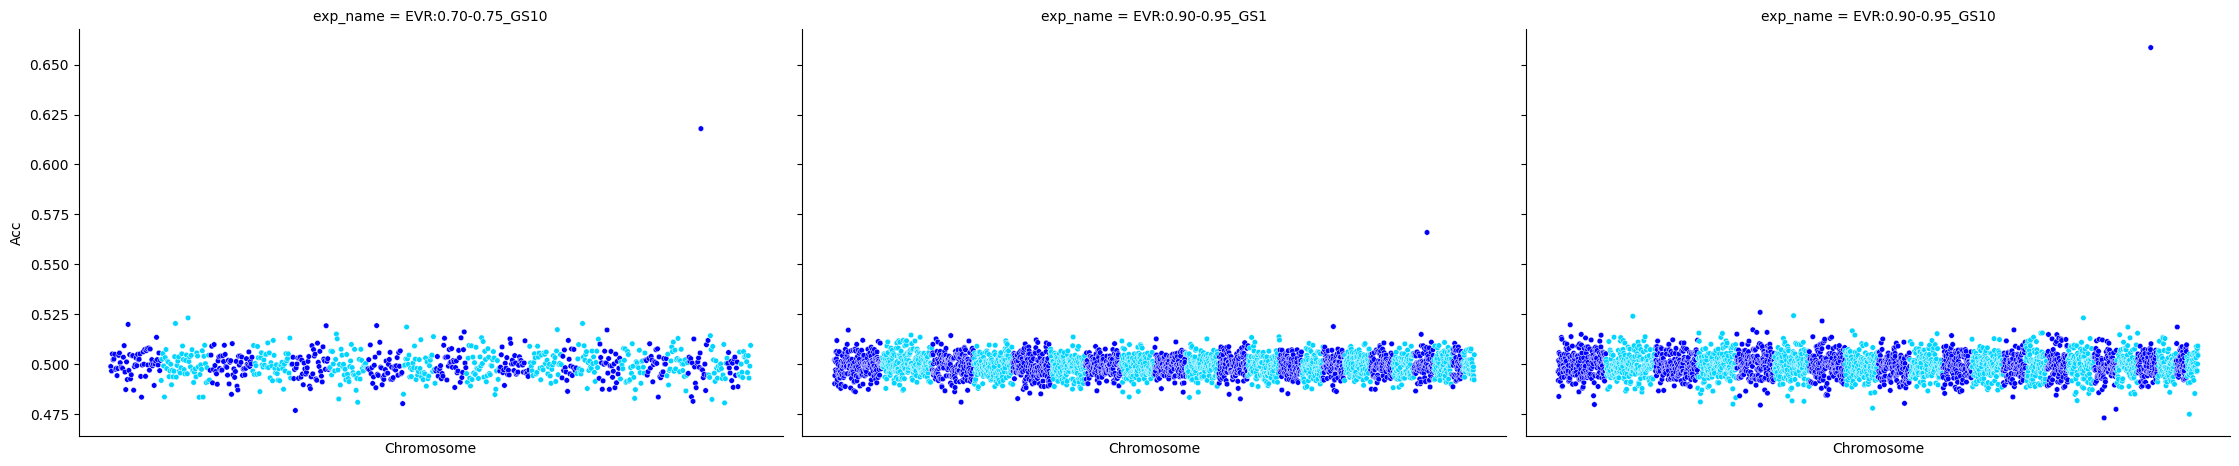

In [60]:
gdf = pd.read_csv('/home/upamanyu/GWANN/GWANN/datatables/gene_annot.csv')
def pos(region):
    start = int(region.split(':')[1].split('-')[0])
    end = int(region.split(':')[1].split('-')[1])
    pos = (start+end)//2
    return pos

def glist(region):
    chrom = int(region.split(':')[0].split('-')[0])
    start = int(region.split(':')[1].split('-')[0])
    end = int(region.split(':')[1].split('-')[1])
    glist = gdf.loc[((gdf['chrom'] == chrom) & 
             (gdf['start'] >= start) & 
             (gdf['end'] <= end))]['symbol'].values
    glist = ' : '.join(glist)
    return glist


manhattan_df = plot_df.copy()
manhattan_df['pos'] = manhattan_df['Gene'].apply(lambda x: pos(x)).values
manhattan_df['glist'] = manhattan_df['Gene'].apply(lambda x: glist(x)).values
manhattan_df_new = []
for g, idx in manhattan_df.groupby('exp_name').groups.items():
    tdf = manhattan_df.loc[idx].copy()
    tdf.sort_values(['Chrom', 'pos'], inplace=True)
    tdf.reset_index(drop=True, inplace=True)
    tdf['pos_idx'] = tdf.index.values + 1
    tdf.sort_values('Acc', ascending=False)[['Gene', 'Acc', 'exp_name', 'glist']].head(10).to_csv(f'./{g}.csv', index=False)
    manhattan_df_new.append(tdf)

manhattan_df_new = pd.concat(manhattan_df_new)
fg = sns.FacetGrid(data=manhattan_df_new, col='exp_name', sharey=True, sharex=False, 
                   height=5, aspect=1.5)
fg.map_dataframe(sns.scatterplot, x='pos_idx', y='Acc', hue='Chrom', alpha=1, s=16,
                 palette=sns.color_palette(['#0000FF', '#00D5FF']*11))
for ax in fg.axes.flatten():
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_xlabel('Chromosome')
plt.show()